이번 과제는 Bert Model을 사용하여 BBC 뉴스 기사의 category를 분류해보는 과제입니다. clone coding을 하시되, 코드 주석을 line by line으로 꼼꼼하게 달아보시며 공부해보세요!

## 데이터 로드 및 탐색

In [4]:
%%capture
!pip install transformers

In [5]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
df = pd.read_csv('/content/drive/MyDrive/kubig/NLP/Week4/bbc-text.csv')

In [9]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [10]:
print(len(df))

2225


In [11]:
df.groupby('category').count()

,text
category,
business,510
entertainment,386
politics,417
sport,511
tech,401


## BertTokenizer

토크나이저로 pretrain된 BERT의 BertTokenizer를 갖고 옵니다. 여러 종류를 시도해보세요.

- bert-base-uncased : 108MB param, all lowercase
- bert-large-cased : 340MB param, both upper and lower
- bert-base-cased : 108MB param, multi language, both upper and lower


In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'business':0,
          'entertainment':1,
          'sport':2,
          'tech':3,
          'politics':4
          }

#각 라벨에 따라 정수화 매핑

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Dataset

In [13]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.labels = [labels[label] for label in df['category']] #category 별 정수화 라벨
        self.texts = [tokenizer(text,
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]
                                #max_length 기준으로 패딩하고, labels 딕셔너리로 카테고리에 해당하는 정수 레이블로 변환

    def classes(self):
        return self.labels #labels 반환

    def __len__(self):
        return len(self.labels) #길이 반환

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx]) #넘파이 배열로 반환

    def get_batch_texts(self, idx):
        return self.texts[idx] #인덱스 따른 텍스트 반환

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        #텍스트, 레이블 반환

        return batch_texts, batch_y

## Train & Evaluate BertClassifier

pretrain된 BertModel을 불러옵니다. 다른 간단한 층들도 같이 쌓아줍니다.

- bert-base-cased: 12-layer, 768-hidden, 12-self attention heads, 110M parameters. Trained on cased English text.


다른 종류들의 pretrianed model은 아래 링크에서 확인할 수 있습니다.

https://huggingface.co/transformers/v2.9.1/pretrained_models.html

In [14]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):
      #dropout: 일부 뉴런 무작위 삭제 -> 의존 방지/ 값이 클수록 많이 삭제/일반적으로 0.2~0.5

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5) #(입력차원/출력차)
        self.relu = nn.ReLU() #비선형함수 추가

    def forward(self, input_id, mask): #순전파 메서드

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        #풀드 출력: 토큰 수준의 표현을 사용해 문장 전체의 표현을 생성
        dropout_output = self.dropout(pooled_output) #드롭아웃으로 과적합 방
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer
        #각 예측확률 출력

Adam optimizer

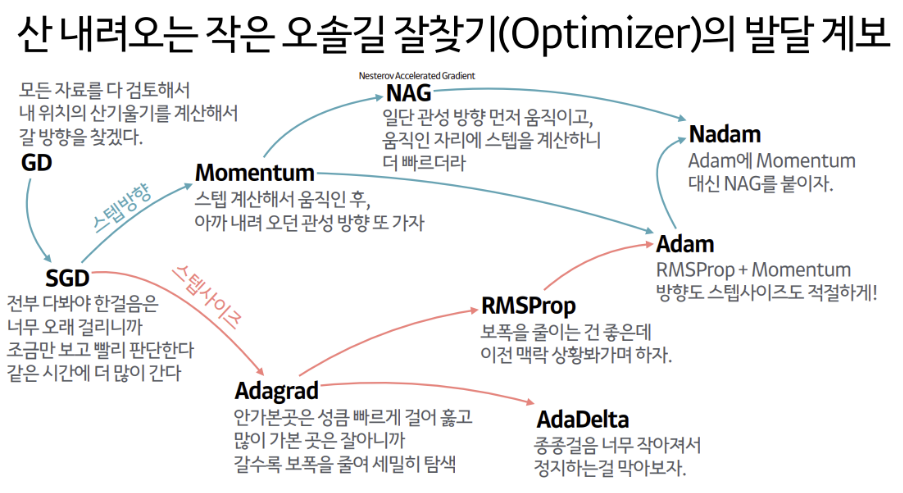

In [15]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss() #교차엔트로피손실함수
    optimizer = Adam(model.parameters(), lr= learning_rate)
    #Adam: 경사하강기법 알고리즘: 기울기 최적화 + 모멘텀

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                #손실 계산 및 합산

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc
                #정확도 계산 및 합산

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
                #역전파로 출

            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
            #각 에폭마다 출


In [16]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0 #정확
    with torch.no_grad(): #그래디언트 계산 X

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item() #예측 결과/실제 레이블을 비교해 정확도 계산
              total_acc_test += acc

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [17]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),
                                     [int(.8*len(df)), int(.9*len(df))])
#df의 행 셔플 및 샘플
print(len(df_train),len(df_val), len(df_test))

1780 222 223


In [18]:
EPOCHS = 2 #EPOCH 수 늘려보기!
model = BertClassifier()
LR = 1e-6

train(model, df_train, df_val, LR, EPOCHS)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

100%|██████████| 890/890 [03:11<00:00,  4.65it/s]


Epochs: 1 | Train Loss:  0.745 | Train Accuracy:  0.379 | Val Loss:  0.634 | Val Accuracy:  0.491


100%|██████████| 890/890 [03:23<00:00,  4.37it/s]


Epochs: 2 | Train Loss:  0.478 | Train Accuracy:  0.714 | Val Loss:  0.331 | Val Accuracy:  0.856


In [19]:
evaluate(model, df_test)

Test Accuracy:  0.879


In [21]:
EPOCHS = 5
model1 = BertClassifier()
LR = 1e-6

train(model1, df_train, df_val, LR, EPOCHS)

100%|██████████| 890/890 [03:18<00:00,  4.48it/s]


Epochs: 1 | Train Loss:  0.707 | Train Accuracy:  0.424 | Val Loss:  0.532 | Val Accuracy:  0.739


100%|██████████| 890/890 [03:23<00:00,  4.37it/s]


Epochs: 2 | Train Loss:  0.386 | Train Accuracy:  0.849 | Val Loss:  0.237 | Val Accuracy:  0.973


100%|██████████| 890/890 [03:23<00:00,  4.37it/s]


Epochs: 3 | Train Loss:  0.189 | Train Accuracy:  0.965 | Val Loss:  0.116 | Val Accuracy:  0.991


100%|██████████| 890/890 [03:23<00:00,  4.38it/s]


Epochs: 4 | Train Loss:  0.104 | Train Accuracy:  0.984 | Val Loss:  0.075 | Val Accuracy:  0.995


100%|██████████| 890/890 [03:23<00:00,  4.37it/s]


Epochs: 5 | Train Loss:  0.062 | Train Accuracy:  0.993 | Val Loss:  0.053 | Val Accuracy:  0.991


In [22]:
evaluate(model1, df_test)

Test Accuracy:  0.991
